In [1]:
import os
import torch
import random
import argparse
import warnings

from peft import AutoPeftModelForCausalLM
from trl import setup_chat_format, SFTTrainer
from datasets import load_dataset, disable_caching
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, TrainingArguments, pipeline

from codecarbon import EmissionsTracker

from utils import init_wandb, build_prompts, get_preds, get_labels, evaluate

warnings.filterwarnings("ignore")

In [2]:
# Free CUDA memory
torch.cuda.empty_cache()

ADAPTER_ID = "kahliahogg/climate-peft"
BASE_ID = "eci-io/climategpt-7b"

# GPU/CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Running evaluation on {device}")

# Load test dataset
test_prompts = load_dataset("json", data_files="data/test_prompts.json", split="train")
print(f"Loaded {test_prompts.num_rows} test samples")

Running evaluation on cuda:0
Loaded 320 test samples


### Evaluate Baseline Model

[codecarbon INFO @ 23:14:18] [setup] RAM Tracking...
[codecarbon INFO @ 23:14:18] [setup] GPU Tracking...
[codecarbon INFO @ 23:14:18] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 23:14:18] [setup] CPU Tracking...
[codecarbon WARNING @ 23:14:18] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 23:14:19] We saw that you have a AMD EPYC 7R32 but we don't know it. Please contact us.
[codecarbon INFO @ 23:14:19] CPU Model on constant consumption mode: AMD EPYC 7R32
[codecarbon INFO @ 23:14:19] >>> Tracker's metadata:
[codecarbon INFO @ 23:14:19]   Platform system: Linux-5.15.0-1045-aws-x86_64-with-glibc2.31
[codecarbon INFO @ 23:14:19]   Python version: 3.9.16
[codecarbon INFO @ 23:14:19]   CodeCarbon version: 2.3.4
[codecarbon INFO @ 23:14:19]   Available RAM : 249.041 GB
[codecarbon INFO @ 23:14:19]   CPU count: 64
[codecarbon INFO @ 23:14:19]   CPU model: AMD EPYC 7R32
[codecarbon INFO @ 23:14:19]   GPU count: 1
[codecarbon INFO @ 23:14:19]   GPU

Test recall: 0.6213084454370551
Test precision: 0.6520258446628079
Test f1: 0.6299130246294741
Test accuracy: 0.68125
Average CO2 emissions/inference: 6.581016637087542e-05


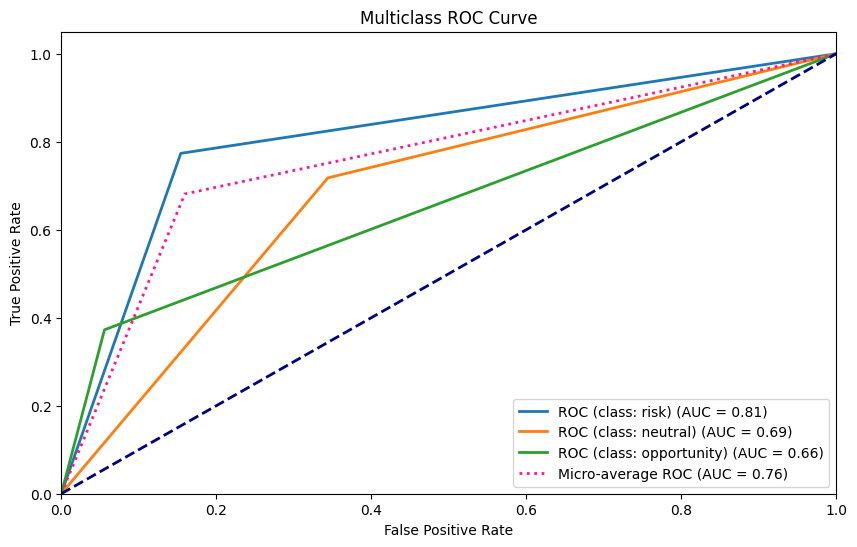

In [3]:
base_tracker = EmissionsTracker(project_name=BASE_ID)

tokenizer = AutoTokenizer.from_pretrained(BASE_ID)
model = AutoModelForCausalLM.from_pretrained(BASE_ID)

# ChatML Config
model, tokenizer = setup_chat_format(model, tokenizer)

# Load merged model into pipeline
pipe = pipeline(
    task="text-generation", 
    model=model, 
    tokenizer=tokenizer
)

# Test Preds
base_tracker.start()
y_preds = get_preds(test_prompts, pipe)
base_co2 = base_tracker.stop()
y_true = get_labels(test_prompts)

# Evaluate
evaluate(y_true, y_preds, ".", log_to_wandb=False)

print(f"Average CO2 emissions/inference: {base_co2/len(y_preds)}")

### Evaluate Finetuned Model

[codecarbon INFO @ 23:50:57] [setup] RAM Tracking...
[codecarbon INFO @ 23:50:57] [setup] GPU Tracking...
[codecarbon INFO @ 23:50:57] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 23:50:57] [setup] CPU Tracking...
[codecarbon WARNING @ 23:50:57] No CPU tracking mode found. Falling back on CPU constant mode.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
[codecarbon WARNING @ 23:50:58] We saw that you have a AMD EPYC 7R32 but we don't know it. Please contact us.
[codecarbon INFO @ 23:50:58] CPU Model on constant consumption mode: AMD EPYC 7R32
[codecarbon INFO @ 23:50:58] >>> Tracker's metadata:
[codecarbon INFO @ 23:50:58]   Platform system: Linux-5.15.0-1045-aws-x86_64-with-glibc2.31
[codecarbon INFO @ 23:50

Test recall: 0.7332824166437807
Test precision: 0.7641642146178436
Test f1: 0.7406381179966086
Test accuracy: 0.76875
Average CO2 emissions/inference: 6.007615463563179e-06


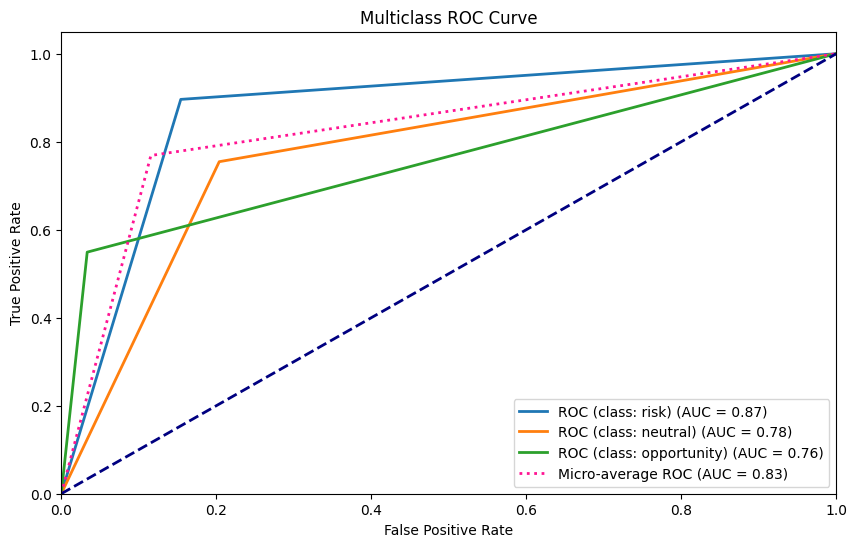

In [4]:
# Free CUDA memory..again
del model
del tokenizer
torch.cuda.empty_cache()

peft_tracker = EmissionsTracker(project_name=ADAPTER_ID)

# Load model with PEFT adapter
model = AutoPeftModelForCausalLM.from_pretrained(
    ADAPTER_ID,
    torch_dtype=torch.float16,
    low_cpu_mem_usage=True,
    device_map=device,
)

tokenizer = AutoTokenizer.from_pretrained(ADAPTER_ID)

# Load merged model into pipeline
pipe = pipeline(
    task="text-generation", 
    model=model, 
    tokenizer=tokenizer
)

# Test Preds
peft_tracker.start()
y_preds = get_preds(test_prompts, pipe)
peft_co2 = peft_tracker.stop()
y_true = get_labels(test_prompts)

# Evaluate
evaluate(y_true, y_preds, ".", log_to_wandb=False)

print(f"Average CO2 emissions/inference: {peft_co2/len(y_preds)}")